# Fashion MNIST Data Science Challenge: Neural Networks and Deep Learning


This file contains the code as well as the explanations to our final model.

## Imports

In [1]:
#basic packages
import typing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import datetime
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# When true explanatory graphs and tensorboard are rendered -> impacts runtime
SHOW_EXPLANATORY_GRAPHS = True

## Data Preparation and Augmentation

  <span style="color:red">*TODO BEWEISE + Methoden*</span>.

### Random erasing

In [3]:
# Import random eraser from its python file
%run random_eraser/random_eraser

### Image rotation

In [4]:
#Image rotation was used for data augmentation. The function names are self-explanatory
def flip_image_vertical(image: np.ndarray) -> np.ndarray:      
    return np.flip(image, axis=1)

def flip_image_horizontal(image: np.ndarray) -> np.ndarray:
    return np.flip(image, axis=0)

def rotate_270(image: np.ndarray) -> np.ndarray:
    return np.rot90(image, -1)

def rotate_90(image: np.ndarray) -> np.ndarray:
    return np.rot90(image, 1)

In [5]:
def augment_images(input_data: np.ndarray)->typing.Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # TODO use vectorize
#     augmentedResults.append(model.predict(np.vectorize(flip_image_vertical)(input_data)))
#     augmentedResults.append(model.predict(np.vectorize(flip_image_horizontal)(input_data)))
#     augmentedResults.append(model.predict(np.vectorize(rotate_270)(input_data)))
#     augmentedResults.append(model.predict(np.vectorize(rotate_90)(input_data)))

    flipped_images_vertical = np.empty(shape=input_data.shape)
    flipped_images_horizontal = np.empty(shape=input_data.shape)
    rot_images_90 = np.empty(shape=input_data.shape)
    rot_images_270 = np.empty(shape=input_data.shape)
    
    for ind, im in enumerate(input_data):
        flipped_images_vertical[ind] = flip_image_vertical(im)
        flipped_images_horizontal[ind] = flip_image_horizontal(im)
        rot_images_90[ind] = rotate_90(im)
        rot_images_270[ind] = rotate_270(im)
        
    return flipped_images_vertical, flipped_images_horizontal, rot_images_90, rot_images_270

### Data Preparation

In [6]:
##@Verena: Wir müssen uns noch absprechen, wie wir hier sinnvoll den Trainingsdatensatz bearbeiten (d.h. wann normalisieren wir usw.)
##Verena: Ich würde zum normalisieren den layer von keras benutzen 
## -> habe temporär oben einen boolean eingeführt um das ein und aus zu schalten
def prepare_training_set(x_train: np.ndarray, y_train: np.ndarray, num_erases:int)->typing.Tuple[np.ndarray, np.ndarray]:
    # @Alle sollten bei jedem training alle augmentierten bilder genutzt werden oder nur zufällig?
    combined_x_train = [x_train]
    aug_from_func = augment_images(x_train)
    combined_x_train.extend(aug_from_func)
    
    # Todo add randomly + combine
    eraser = get_random_eraser()  # TODO parameters 
    combined_x_train.extend([[eraser(im) for im in x_train] for _ in range(num_erases)])
    
    if SHOW_EXPLANATORY_GRAPHS:
        # show augmented images
        for ind, aug_list in enumerate(combined_x_train):
            plt.figure()
            plt.imshow(aug_list[0].reshape((28,28)))
            plt.colorbar()
            plt.grid(False)
            plt.title("Augmented image {}".format(ind))
            plt.show()
    # Flatten list
    combined_x_train = np.concatenate(combined_x_train)  #TODO check
    #combined_y_train = np.concatenate([y_train for _ in range(5 + num_erases)])  # TODO use numpy tile
    combined_y_train = np.tile(y_train, 5 + num_erases)
    
    return x_train, y_train
    #return combined_x_train, combined_y_train  # TODO this

In [7]:
#1. Get the file
data_train = pd.read_csv('train.csv')
data_validate = pd.read_csv('test.csv')
data_train = np.array(data_train, dtype = 'float32') # Damit Input Daten von Keras akzeptiert werden müssen wir sie in ein Array umwandeln 
data_validate = np.array(data_validate, dtype='float32') 

In [8]:
# TODO temporary for normalization layer usage
use_norm_layer = True

In [9]:
x_train = data_train[:,1:]

if not use_norm_layer:
    x_train = data_train[:,1:]/255 #pixel data from 0-1

y_train = data_train[:,0] #label data

data_submission = data_validate

if not use_norm_layer:
    data_submission = data_validate/255

In [10]:
#reshape the array containing the images (28px x 28px and 1 channel)
image_rows = 28
image_cols = 28
image_shape = (image_rows,image_cols,1)# 1 da schwarz weiß, bei Farbbildern 3 (r,g,b)

x_train = x_train.reshape(x_train.shape[0],*image_shape)
data_submission = data_submission.reshape(data_submission.shape[0],*image_shape)

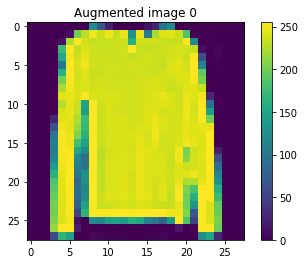

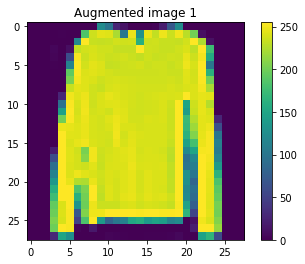

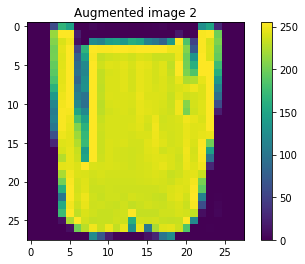

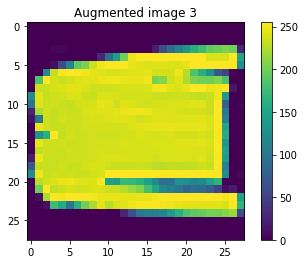

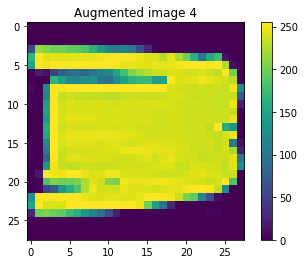

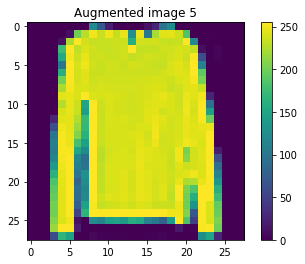

(360000, 28, 28, 1)
(360000,)


In [11]:
# Use extended dataset
# TODO comment
x_train, y_train = prepare_training_set(x_train, y_train, 1)

In [12]:
#split train data in train and validation set
x_train2,x_validate2,y_train2,y_validate2 = train_test_split(x_train,y_train,test_size = 0.2,random_state = 12345)

#### Set up Tensorboard

In [ ]:
# Set up tensor board (using https://neptune.ai/blog/tensorboard-tutorial   
# and 
# https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb)

if SHOW_EXPLANATORY_GRAPHS:
    from tensorflow.keras.callbacks import TensorBoard# zur Visualisierung
    import datetime
    import itertools 
    import io

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    log_parent_folder = "logs/" + current_time
    #log_folder = log_parent_folder + "/fit/"

    class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker","Bag", "Ankle boot"]
    #plot_dir = log_parent_folder + "/plots/"
    #cm_dir = log_parent_folder + "/cm/"
    file_writer_cm = tf.summary.create_file_writer(log_parent_folder)
    file_writer = tf.summary.create_file_writer(log_parent_folder)

    def plot_to_image(figure: plt.Figure):    
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(figure)
        buf.seek(0)

        digit = tf.image.decode_png(buf.getvalue(), channels=4)
        digit = tf.expand_dims(digit, 0)

        return digit

    def plot_confusion_matrix(cm, class_names: np.ndarray) ->plt.Figure: 
        figure = plt.figure(figsize=(8, 8)) 
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
        plt.title("Confusion matrix") 
        plt.colorbar() 
        tick_marks = np.arange(len(class_names)) 
        plt.xticks(tick_marks, class_names, rotation=45) 
        plt.yticks(tick_marks, class_names)

        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
        threshold = cm.max() / 2. 

        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
            color = "white" if cm[i, j] > threshold else "black"   
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  

        plt.tight_layout() 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label') 

        return figure

    def log_confusion_matrix(epoch: int, logs: typing.Dict[str, float])->None:
        predictions = model.predict(x_validate2)
        predictions = np.argmax(predictions, axis=1)

        cm = confusion_matrix(y_validate2, predictions)
        figure = plot_confusion_matrix(cm, class_names=class_names)
        cm_image = plot_to_image(figure)

        with file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)


    tensorboard_callbacks = [TensorBoard(log_dir=log_parent_folder,
                             histogram_freq=1,
                             write_graph=True,
                             write_images=True,
                             update_freq='epoch',
                             profile_batch=2,
                             embeddings_freq=1),
                             tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)]
else:
    tensorboard_callbacks = []

In [ ]:
if SHOW_EXPLANATORY_GRAPHS:
    %load_ext tensorboard

## Modeling

### Parameters

Mostly we decided our parameters by doing hyperparameter tuning via trial and error.

In [ ]:
#@felix dein code hier
NUM_EPOCHS = 0
INIT_LR = 1e-3
BATCH_SIZE = 128
L2_PENALTY = 0.003

#### Optimizer
There are multiple articles mentioning SGD as the best optimizer in the long term.
[This article](https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/) compares the Adam and SGD optimizer and concludes that SGD with momentum and Nesterov results in a better validation accuracy.
Other articles suggest that even though Adam is faster in the beginning but SGD has better convergence in the long run.

Even though SGD might take more epochs to train, the network's accuracy ends up to be more stable.

In [ ]:
our_optimizer = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR/NUM_EPOCHS)

#### Loss Function
  <span style="color:red">*Explanation*</span>.

In [ ]:
our_loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

#### Activation Functions
  <span style="color:red">*Explanation*</span>.

In [ ]:
model = Sequential([
        #3 convolutional layers followed by a max pooling layer
        Conv2D(32, kernel_size=3, activation='relu', input_shape=x_train.shape[1:], padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(32, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        #next 3 convolutional layers followed by max pooling layer
        Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
    
        #3 dense layers followed by output layer
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(L2_PENALTY)),
        BatchNormalization(),
        Dense(256, activation='relu', kernel_regularizer=l2(L2_PENALTY)),
        Dropout(0.25),

        Dense(256, activation='relu', kernel_regularizer=l2(L2_PENALTY)),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

if use_norm_layer:
    model = Sequential([
        Normalization(input_shape=x_train.shape[1:]),  # TODO values
        model
    ])

In [ ]:
model.summary()

## Kompilieren des Modells

In [ ]:
model.compile(optimizer = our_optimizer,
                  loss= our_loss_function,
                  metrics = ['accuracy'])

## Training

In [ ]:
history = model.fit(
    x_train2,
    y_train2,
    epochs=NUM_EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=(x_validate2,y_validate2),
    callbacks=tensorboard_callbacks
    )

Launch TensorBoard

In [ ]:
if SHOW_EXPLANATORY_GRAPHS:
    %tensorboard --logdir={log_parent_folder}

## Prediction

We use a custom algorithm for image prediction.
### Grid Search
When predicting, the image is augmented in multiple ways before forwaring it to the model. Each of these augmented images is evaluated by the model. Afterwards the mean of the resulting categories is calculated and used as actual prediction.

### Impact
This method results in a more stable prediction.  <span style="color:red">*TODO BEWEISE + Mehr schreiben*</span>.

In [ ]:
def predict(input_data: np.ndarray) -> np.ndarray:
    assert(input_data[0].shape == (28,28,1))
    augmentedResults = []
    
    augmentedResults.append(model.predict(input_data))
    
    flipped_images_vertical, flipped_images_horizontal, rot_images_90, rot_images_270 = augment_images(x_train)
          
    augmentedResults.append(model.predict(flipped_images_vertical))
    augmentedResults.append(model.predict(flipped_images_horizontal))
    augmentedResults.append(model.predict(rot_images_90))
    augmentedResults.append(model.predict(rot_images_270))
    
    # TODO check axis
    return (np.sum(augmentedResults, axis=0) / len(augmentedResults))

# Returns the accuracy
def evaluate(input_data: np.ndarray, input_labels: np.ndarray) -> float:
    assert(len(input_data) == len(input_labels))
    prediction = predict(input_data)
    prediction = np.argmax(prediction, axis = 1)
    
    # TODO check calculation
    return np.count_nonzero(prediction == input_labels) / len(input_labels)

## Visualization

In [ ]:
score_non_grid = model.evaluate(x_validate2,y_validate2,verbose=0)
score_grid = evaluate(x_validate2,y_validate2)
print('Test Accuracy without grid: {:.4f}'.format(score_non_grid[1]))
print('Test Accuracy with grid: {:.4f}'.format(score_grid))

In [ ]:
if SHOW_EXPLANATORY_GRAPHS:
    # Training Loss
    plt.figure(figsize=(20, 10))

    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training - Loss Function')

In [ ]:
if SHOW_EXPLANATORY_GRAPHS:
    # Training Accuracy
    plt.figure(figsize=(20, 10))

    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training - Accuracy Function')

In [ ]:
if SHOW_EXPLANATORY_GRAPHS:
    # Confusion matrix with grid
    val_pred = np.argmax(predict(x_validate2), axis = 1)

    conf_matrix = pd.DataFrame(confusion_matrix(y_validate2, val_pred), index=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker","Bag", "Ankle boot"])
    plt.figure(figsize = (10,7))
    sns.heatmap(conf_matrix, annot=True)

In [ ]:
if SHOW_EXPLANATORY_GRAPHS:
    # Confusion matrix without grid
    val_pred = np.argmax(model.predict(x_validate2), axis = 1)

    conf_matrix = pd.DataFrame(confusion_matrix(y_validate2, val_pred), index=["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker","Bag", "Ankle boot"])
    plt.figure(figsize = (10,7))
    sns.heatmap(conf_matrix, annot=True)

## Submission

In [ ]:
# predict results
results = model.predict(data_submission)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
data_results = pd.DataFrame(results)
data_results.to_csv('fashion_mnist_pred_team1.csv', index=False)#Bitte statt X eure Gruppennummer einfügen! 

## Our Learnings
In the following part we reflect on our network and mention multiple points that could be improved for better classification performance.

### Parameters
Currently the hyperparameter tuning is done manually, but there are libraries (Like [this one](https://keras-team.github.io/keras-tuner/)) that implement systematic hyperparameter tuning. Since this process takes long and is very expensive (each setting needs to be tested after each other), and we (sadly) do not have the computational power to execute the process, we decided against using it. 


### Network Structure
In order to keep the computational complexity as low as possible we decided to use a more shallow structure.
Even though it performs very well research as well as the [official zalando github](https://github.com/zalandoresearch/fashion-mnist) suggest that a deeper network topography contributes to a more accurate classificaion.  <span style="color:red">*TODO ARTIKEL*</span>.

Additionally other structures like DenseNet (described in [this paper](https://arxiv.org/abs/1608.06993)) or ResNet variations can be used to boost accuracy. Tensorflow offers a wide range of pretrained models that can be easily used ([list here](https://www.tensorflow.org/api_docs/python/tf/keras/applications)).

### Data Preprocessing
While we used rudimentary data preprocessing functions, the model can benefit from a more extensive use of these methods. [This library](https://github.com/mdbloice/Augmentor) implements various image preprocessing functions that are well-suited for this purpose. Nethertheless the currently implemented preprocessor already increased the model's capability of generalization. A downside is that the accuracy fluctautes heavily in the beginning and training takes more epochs.  <span style="color:red">*TODO BEWEISE*</span>.

### Errors
<span style="color:red">*TODO name + text*</span>
The confusion matrix shows, that the network displays very poor classification capabilities on some classes (like dresses and shirts) whereas it has no difficulty categorizing others (i.e. boots and bags). Sadly we were not able to eliminate these shortcomings. However one of the methods presented above might be to do so.